# Setting a custom anchor

This notebook gives an example how to add a custom anchor to your analysis using the main `qpcr` module.
It makes use of the provided example data in the `Example Data` directory. 


#### Experimental background

The corresponding experimental setup was as follows: 
Levels of Nonsense-mediated mRNA decay (NMD) sensitive (nmd) and insensitive (prot) transcript isoforms of HNRNPL and SRSF11 were measured by qPCR. As normalisers both 28S rRNA and Actin transcript levels were measured. The replicates are biological triplicates and technical douplicates. All measurements from the same qPCR sample were merged into hexaplicates (6 replicates). This was done in two separate HeLa cell lines (one with a specific gene knockout (KO), and one without (WT)), which were both treated to a plasmid-mediated rescue (+) or not (-), leading to four experimental conditions:


| cell line \\ condition | rescue | no rescue |
| ---------------------- | ------ | --------- |
| knockout               | KO+    | KO-       |
| wildtype               | WT+    | WT-       |



#### First Analysis
The first Delta-Ct makes use of a dataset internal reference value (in our case the measured Ct from untreated wildtype (WT-)). Commonly the average of the reference Ct replicate values is used. The `qpcr` module opted to just use the very first entry of the dataset by default (assuming, of course, that the first group of replicates represents the reference group). However, what if you really want to use the average of the reference group to be the anchor? Well, in this case you can specify an anchor externally and add it directly to the `qpcr.Analyser`. We will see how to do this in this tutorial.

In [1]:
# import the qpcr module
import qpcr
from qpcr.Plotters import PreviewResults

Step 1 - Getting the data
---

First  we get the datafiles (or rather their filepaths). Here, we do this manually. Of course, any more automated process that yields a list of filepaths is also suitable.

In [2]:
# get our datafiles
normaliser_files = [
                        "./Example Data/28S.csv",
                        "./Example Data/actin.csv"
                ]

sample_files = [
                    "./Example Data/HNRNPL_nmd.csv",
                    "./Example Data/HNRNPL_prot.csv",
                    "./Example Data/SRSF11_nmd.csv",
                    "./Example Data/SRSF11_prot.csv",
            ]

# define our experimental parameters
reps = 6
group_names = ["WT-", "WT+", "KO-", "KO+"] 

Step 2 - Setting up the Pipeline
---

### 2.1 Setting up the Pipeline
We are already familiar how to manually set up an analysis pipeline. If you are still unfamiliar with these steps, please check out the first tutorial in the `1_manual_tutorial.ipynb` notebook.

In [3]:
# setup the reader
reader = qpcr.DataReader()

# now we define the setup parameters
# define the number of replicates for each group (group = condition)
reps = 6


# define the names of the groups of replicates = names of conditions
# NOTE: The order has to match the order wihtin the raw datafile!
group_names = ["WT-", "WT+", "KO-", "KO+"] 

# setup analyser
analyser = qpcr.Analyser()

# setup normaliser
normaliser = qpcr.Normaliser()

### 2.2 Setting up the external anchor
Now comes the interesting part. We can specify a custom anchor by computing the anchor externally and then pass the computed numeric value directly to the analyser. 

To make this more convenient, we will write a little function that will get the first replicate group, and average the Ct values.

However, if we already have defined a function then we can also directly add that function to the `qpcr.Analyser`. The `qpcr.Analyser` offers the argument `data` which allows the custom anchor function to access a `qpcr.Assay`'s dataframe. 

It is really up to you if you would rather call the custom anchor function directly and only pass the numeric value as new anchor to the `qpcr.Analyser` or if you would prefer linking the function directly. If your custom anchor function requires additional arguments than just `data`, it may be saver to call it directly instead of linking it. 

> Note
>
> When writing a custom anchor function, please, make sure it can handle `**kwargs` because it will recieve any kwargs that may have been passed during `DeltaCt()` calling!

In [4]:
def first_average(data, **kwargs):
    """
    This function gets the first group (group 0), which is the reference group, 
    and returns their average Ct value. 
    
    It is also able to handle any **kwargs that could potentially be passed
    alongside data, just to make sure it does not raise an error in such cases.

    It works with a the pandas dataframe of a qpcr.Assay
    object provided by the qpcr.Analyser...
    """
    ref = data.query("group == 0")["Ct"]
    avg = ref.mean()
    return avg

Now we can add this function as the `anchor` of our `qpcr.Analyser` like: 

In [5]:
analyser.anchor(first_average)

(<function __main__.first_average(data, **kwargs)>, 0)

Step 3 - Running everything
---
Now we take the workflow from the first tutorial.

In [6]:
normalisers = reader.read(normaliser_files, replicates = reps, names = group_names)
normalisers = analyser.pipe(normalisers)

assays = reader.read(sample_files, replicates = reps, names = group_names)
assays = analyser.pipe(assays)

> Note
> 
> We could also have done something like this, where we first get the assay data, then compute the anchor externally and then supply it back to the analyser before piping: 
>
>```python
>    normalisers = []
>    for norm in normaliser_files:
>        norm = reader.read(norm, replicates = reps, names = group_names)
>        
>        # externally compute custom anchor
>        df = norm.get()
>        custom_anchor = first_average(df)
>        analyser.anchor(custom_anchor)
>        
>        norm = analyser.pipe(norm)
>        normalisers.append(norm)
>```

### 3.2 Finishing up
At this point we simply need to run the second step in Delta-Delta-Ct, the normalisation against our normaliser assays Actin and 28S. And inspect the results afterward.

In [7]:
# pipe assays through the normaliser 
results = normaliser.pipe(assays = assays, normalisers = normalisers)

results = results.stats()
results

,group,group_name,assay,n,mean,stdev,median,"IQR_(0.25, 0.75)",CI_0.95
0,0,WT-,HNRNPL_nmd_rel_28S+actin,6,0.996925,0.031751,1.001800,0.030918,"[0.9604241234037599, 1.033426479788407]"
4,1,WT+,HNRNPL_nmd_rel_28S+actin,6,5.650216,0.835556,5.926360,1.427433,"[4.689661719146076, 6.6107698211229176]"
8,2,KO-,HNRNPL_nmd_rel_28S+actin,6,9.148520,0.473316,9.180616,0.678068,"[8.604397017660883, 9.692643897991115]"
12,3,KO+,HNRNPL_nmd_rel_28S+actin,6,16.185170,1.188382,16.143396,1.154838,"[14.81900740742402, 17.551333471054246]"
1,0,WT-,HNRNPL_prot_rel_28S+actin,6,0.997374,0.044757,0.983061,0.023185,"[0.9459207746093615, 1.048826826812926]"
5,1,WT+,HNRNPL_prot_rel_28S+actin,6,0.873953,0.050710,0.876917,0.040587,"[0.8156563755514737, 0.9322488113660846]"
9,2,KO-,HNRNPL_prot_rel_28S+actin,6,0.839504,0.031261,0.845369,0.028303,"[0.8035663011582339, 0.8754415164331928]"
13,3,KO+,HNRNPL_prot_rel_28S+actin,6,0.906150,0.063912,0.910838,0.083418,"[0.8326769774200075, 0.9796239568651376]"
2,0,WT-,SRSF11_nmd_rel_28S+actin,6,1.002857,0.114905,0.979897,0.188014,"[0.8707620979409529, 1.1349519145870646]"
6,1,WT+,SRSF11_nmd_rel_28S+actin,6,3.758608,0.711593,4.048361,0.913995,"[2.940560872156249, 4.576654223178983]"


Default `"first"` vs. custom `"mean"` anchor
----------------------------------------------------------------

You may be wondering how the results differ between the default settings and the ones using our custom mean-anchor. Let's compare the results. We will compute results using default settings through the predefined `Basic` pipeline. 

In [8]:
# get default results using the Basic pipeline
from qpcr.Pipes import Basic

basic = Basic()
basic.replicates(reps)
basic.names(group_names)
basic.add_assays(sample_files)
basic.add_normalisers(normaliser_files)
basic.run()
results_pipe = basic.get()

results_pipe

,group,group_name,assay,n,mean,stdev,median,"IQR_(0.25, 0.75)",CI_0.95
0,0,WT-,HNRNPL_nmd_rel_28S+actin,6,1.050056,0.029452,1.050267,0.038511,"[1.0161980755868047, 1.0839147340669306]"
4,1,WT+,HNRNPL_nmd_rel_28S+actin,6,6.052860,0.890336,6.366251,1.516539,"[5.029330209330722, 7.076390063511062]"
8,2,KO-,HNRNPL_nmd_rel_28S+actin,6,9.566500,0.513593,9.614924,0.734027,"[8.976073861884581, 10.156926829088912]"
12,3,KO+,HNRNPL_nmd_rel_28S+actin,6,16.940332,1.126687,16.964906,1.096016,"[15.645093462670095, 18.235569627233723]"
1,0,WT-,HNRNPL_prot_rel_28S+actin,6,1.025239,0.040091,1.006244,0.028966,"[0.9791503057437683, 1.0713284193830188]"
5,1,WT+,HNRNPL_prot_rel_28S+actin,6,0.913758,0.050860,0.917271,0.042987,"[0.8552897342904139, 0.9722270525874591]"
9,2,KO-,HNRNPL_prot_rel_28S+actin,6,0.856658,0.029906,0.862768,0.028070,"[0.8222776478939225, 0.891038325780611]"
13,3,KO+,HNRNPL_prot_rel_28S+actin,6,0.925665,0.057855,0.931949,0.073664,"[0.859154910656904, 0.9921743211393722]"
2,0,WT-,SRSF11_nmd_rel_28S+actin,6,0.885403,0.102865,0.857620,0.172183,"[0.7671489539924317, 1.0036564706179987]"
6,1,WT+,SRSF11_nmd_rel_28S+actin,6,3.374373,0.638138,3.644576,0.813222,"[2.6407697994029142, 4.107976488500923]"


Next we visualise the results as barplots and check the fold-change between our custom results and the default results.

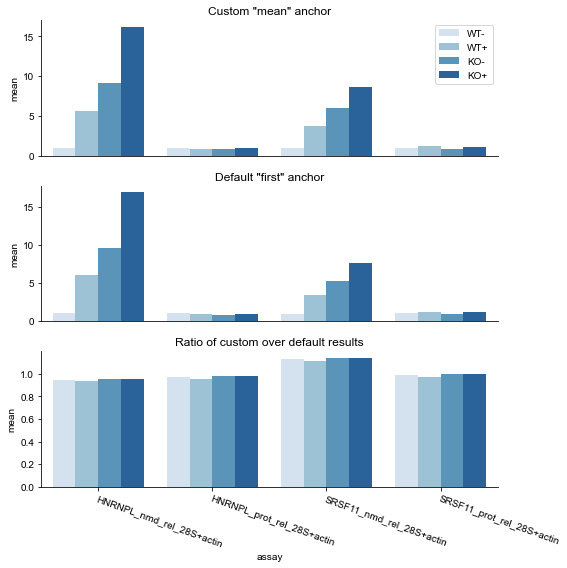

In [9]:
# visualise our results (we can ignore the code here, just the figure is of interest...)
import matplotlib.pyplot as plt
import seaborn as sns 

fig, axs = plt.subplots(3, figsize = (8,8))

sns.barplot(
            data = results, 
            x = "assay", 
            y = "mean", 
            hue = "group_name", 
            palette = "Blues",
            ax = axs[0]
        )

sns.barplot(
            data = results_pipe, 
            x = "assay", 
            y = "mean", 
            hue = "group_name", 
            palette = "Blues",
            ax = axs[1]
        )

diff_means = results["mean"] / results_pipe["mean"]

sns.barplot(
    data = results,
    x = "assay",
    y = diff_means,
    hue = "group_name",
    palette = "Blues",
    ax = axs[2]
)

for ax in axs: 
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-20, ha="left", rotation_mode="anchor") 
    ax.legend().remove()
    ax.set(xlabel="", xticks = [])
axs[0].legend()
axs[2].set(xlabel = "assay", xticks = [0,1,2,3])

axs[0].set(title = "Custom \"mean\" anchor")
axs[1].set(title = "Default \"first\" anchor")
axs[2].set(title = "Ratio of custom over default results")
sns.set_style("ticks")
sns.despine()
plt.tight_layout()

In our example dataset, computing an external anchor did not seem to impact our overall results markedly. Well, that's a relief :-) 

So, does that mean we should simply rely on default settings? Not necessarily. If your data is spread over a larger range of Ct values for each group (you can check the distribution of your data using the `qpcr.Filter` classes, see the third tutorial `3_filter_tutorial.ipynb`), you may not want to rely on a just the first one of your datapoints to be your anchor (after all it could just barely have passed the filter). In such cases you may rather want to rely on a mean or median of your entire reference group.

A little note at the end: You may have already realised that our little example is actually already a pre-implemented `anchor` of the `qpcr.Analyser` called the `"mean"` anchor. So we can achieve the exact same result by simply calling `analyser.anchor("mean")` without having to specify our own function for it. 